In [191]:
# Essentials
import os
import random
import numpy as np
import pandas as pd
from collections import defaultdict

# Images
from PIL import Image

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, label_binarize
from skimage import transform, exposure, io
from skimage.feature import hog
from skimage.transform import resize

#Accuracy 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, silhouette_score

print("Setup Complete")

Setup Complete


# Loading Dataframe

In [192]:


def process_utkface_data(src_folder):
    age = []
    gender = []
    image_path = []
    race = []

    for filename in (os.listdir(src_folder)):
        data_path = os.path.join(src_folder, filename)
        temp = filename.split('_')
        data_age = temp[0]
        data_gender = temp[1]
        data_race = temp[2]
        race.append(data_race)
        age.append(data_age)
        gender.append(data_gender)
        image_path.append(data_path)
    
    return image_path, age, gender, race





#### Create dataframe

In [193]:
image_path, age, gender, race = process_utkface_data('src/utkface/')

In [194]:

df = pd.DataFrame()
df['image'],df['age'],df['gender'],df['race'] = image_path,age,gender,race
df.head(5)


,image,age,gender,race
0,src/utkface/100_0_0_20170112213500903.jpg.chip...,100,0,0
1,src/utkface/100_0_0_20170112215240346.jpg.chip...,100,0,0
2,src/utkface/100_1_0_20170110183726390.jpg.chip...,100,1,0
3,src/utkface/100_1_0_20170112213303693.jpg.chip...,100,1,0
4,src/utkface/100_1_0_20170112215032192.jpg.chip...,100,1,0


## Reduce Images

In [195]:
# # run it for once only 
# percentage = 0.3

# age_gender_groups = defaultdict(list)
# for index, row in df.iterrows():
#     age = row['age']
#     gender = row['gender']
#     image_path = row['image']
#     age_gender_groups[(age, gender)].append(image_path)


# path = 'src'
# temp_folder = os.path.join(path, 'temp')
# os.makedirs(temp_folder, exist_ok=True)

# for (age, gender), files in age_gender_groups.items():
#     random.shuffle(files)
#     num_files_test = min(int(percentage * len(files)), len(files))
#     selected_files = files[:num_files_test]
    
#     # cut images
#     for test_file in selected_files:
#         src = test_file 
#         filename = os.path.basename(src)
#         dest = os.path.join(temp_folder, filename)
#         os.rename(src, dest)

Create the dataframe with less rows

In [196]:
image_path, age, gender, race = process_utkface_data('src/utkface/')

In [197]:
df = pd.DataFrame()
df['image'],df['age'],df['gender'],df['race'] = image_path,age,gender,race
df.head(5)

,image,age,gender,race
0,src/utkface/100_0_0_20170112213500903.jpg.chip...,100,0,0
1,src/utkface/100_0_0_20170112215240346.jpg.chip...,100,0,0
2,src/utkface/100_1_0_20170110183726390.jpg.chip...,100,1,0
3,src/utkface/100_1_0_20170112215032192.jpg.chip...,100,1,0
4,src/utkface/100_1_0_20170119212053665.jpg.chip...,100,1,0


## Data Exploration

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11764 entries, 0 to 11763
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   11764 non-null  object
 1   age     11764 non-null  object
 2   gender  11764 non-null  object
 3   race    11764 non-null  object
dtypes: object(4)
memory usage: 367.8+ KB


In [199]:
print(df.shape)
gender_dict = {0:'Male', 1:'Female'}
race_dict = {0:'White', 1:'Black', 2:"Asian", 3:"Indian", 4:"Others"}

(11764, 4)


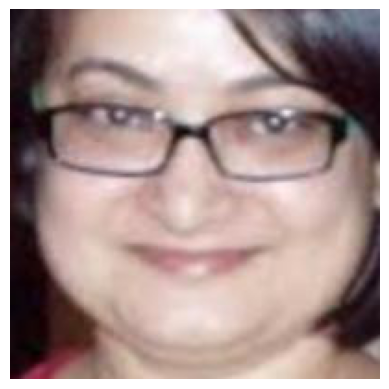

In [200]:
img = Image.open(df.sample().values[0,0])
plt.axis("off")
plt.imshow(img)

## Preprocessing

In [201]:
df['gender'].value_counts()

0    6146
1    5617
3       1
Name: gender, dtype: int64

In [202]:
wrong_gender = df[df['gender'] == '3'].index
wrong_gender
df.drop(wrong_gender,inplace=True)

In [203]:
df['gender'].value_counts()

0    6146
1    5617
Name: gender, dtype: int64

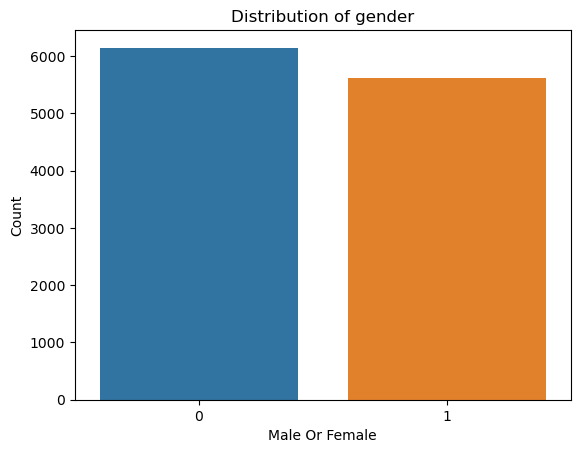

In [204]:
sns.countplot(x=df['gender'], data=df)
plt.title('Distribution of gender')
plt.xlabel('Male Or Female')
plt.ylabel('Count')
plt.show()

In [205]:
df['image']

0        src/utkface/100_0_0_20170112213500903.jpg.chip...
1        src/utkface/100_0_0_20170112215240346.jpg.chip...
2        src/utkface/100_1_0_20170110183726390.jpg.chip...
3        src/utkface/100_1_0_20170112215032192.jpg.chip...
4        src/utkface/100_1_0_20170119212053665.jpg.chip...
                               ...                        
11759     src/utkface/9_1_2_20170102235115156.jpg.chip.jpg
11760     src/utkface/9_1_2_20170104020210475.jpg.chip.jpg
11761     src/utkface/9_1_3_20161219225144784.jpg.chip.jpg
11762     src/utkface/9_1_3_20161220222856346.jpg.chip.jpg
11763     src/utkface/9_1_4_20170103200814791.jpg.chip.jpg
Name: image, Length: 11763, dtype: object

In [206]:
duplicate_rows = df[df.duplicated(subset=['image'] , keep=False)]
duplicate_rows

# there are no duplicate images

,image,age,gender,race


In [207]:
df['age'].value_counts()

26     1078
1       552
28      451
35      433
24      422
       ... 
93        3
101       2
91        2
111       1
103       1
Name: age, Length: 104, dtype: int64

In [208]:
df['race'].value_counts()


0                                 5000
1                                 2231
3                                 1976
2                                 1720
4                                  833
20170116174525125.jpg.chip.jpg       1
20170109142408075.jpg.chip.jpg       1
20170109150557335.jpg.chip.jpg       1
Name: race, dtype: int64

In [209]:
races = ['0','1','2','3','4']

indices_to_drop = df[~df['race'].isin(races)].index

df.drop(indices_to_drop,inplace=True)

In [210]:
df['race'].value_counts()


0    5000
1    2231
3    1976
2    1720
4     833
Name: race, dtype: int64

In [211]:
df['age'] = df['age'].astype(int)
df['race'] = df['race'].astype(int)
df['gender'] = df['gender'].astype(int) 

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11760 entries, 0 to 11763
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   11760 non-null  object
 1   age     11760 non-null  int32 
 2   gender  11760 non-null  int32 
 3   race    11760 non-null  int32 
dtypes: int32(3), object(1)
memory usage: 321.6+ KB


## Visualization

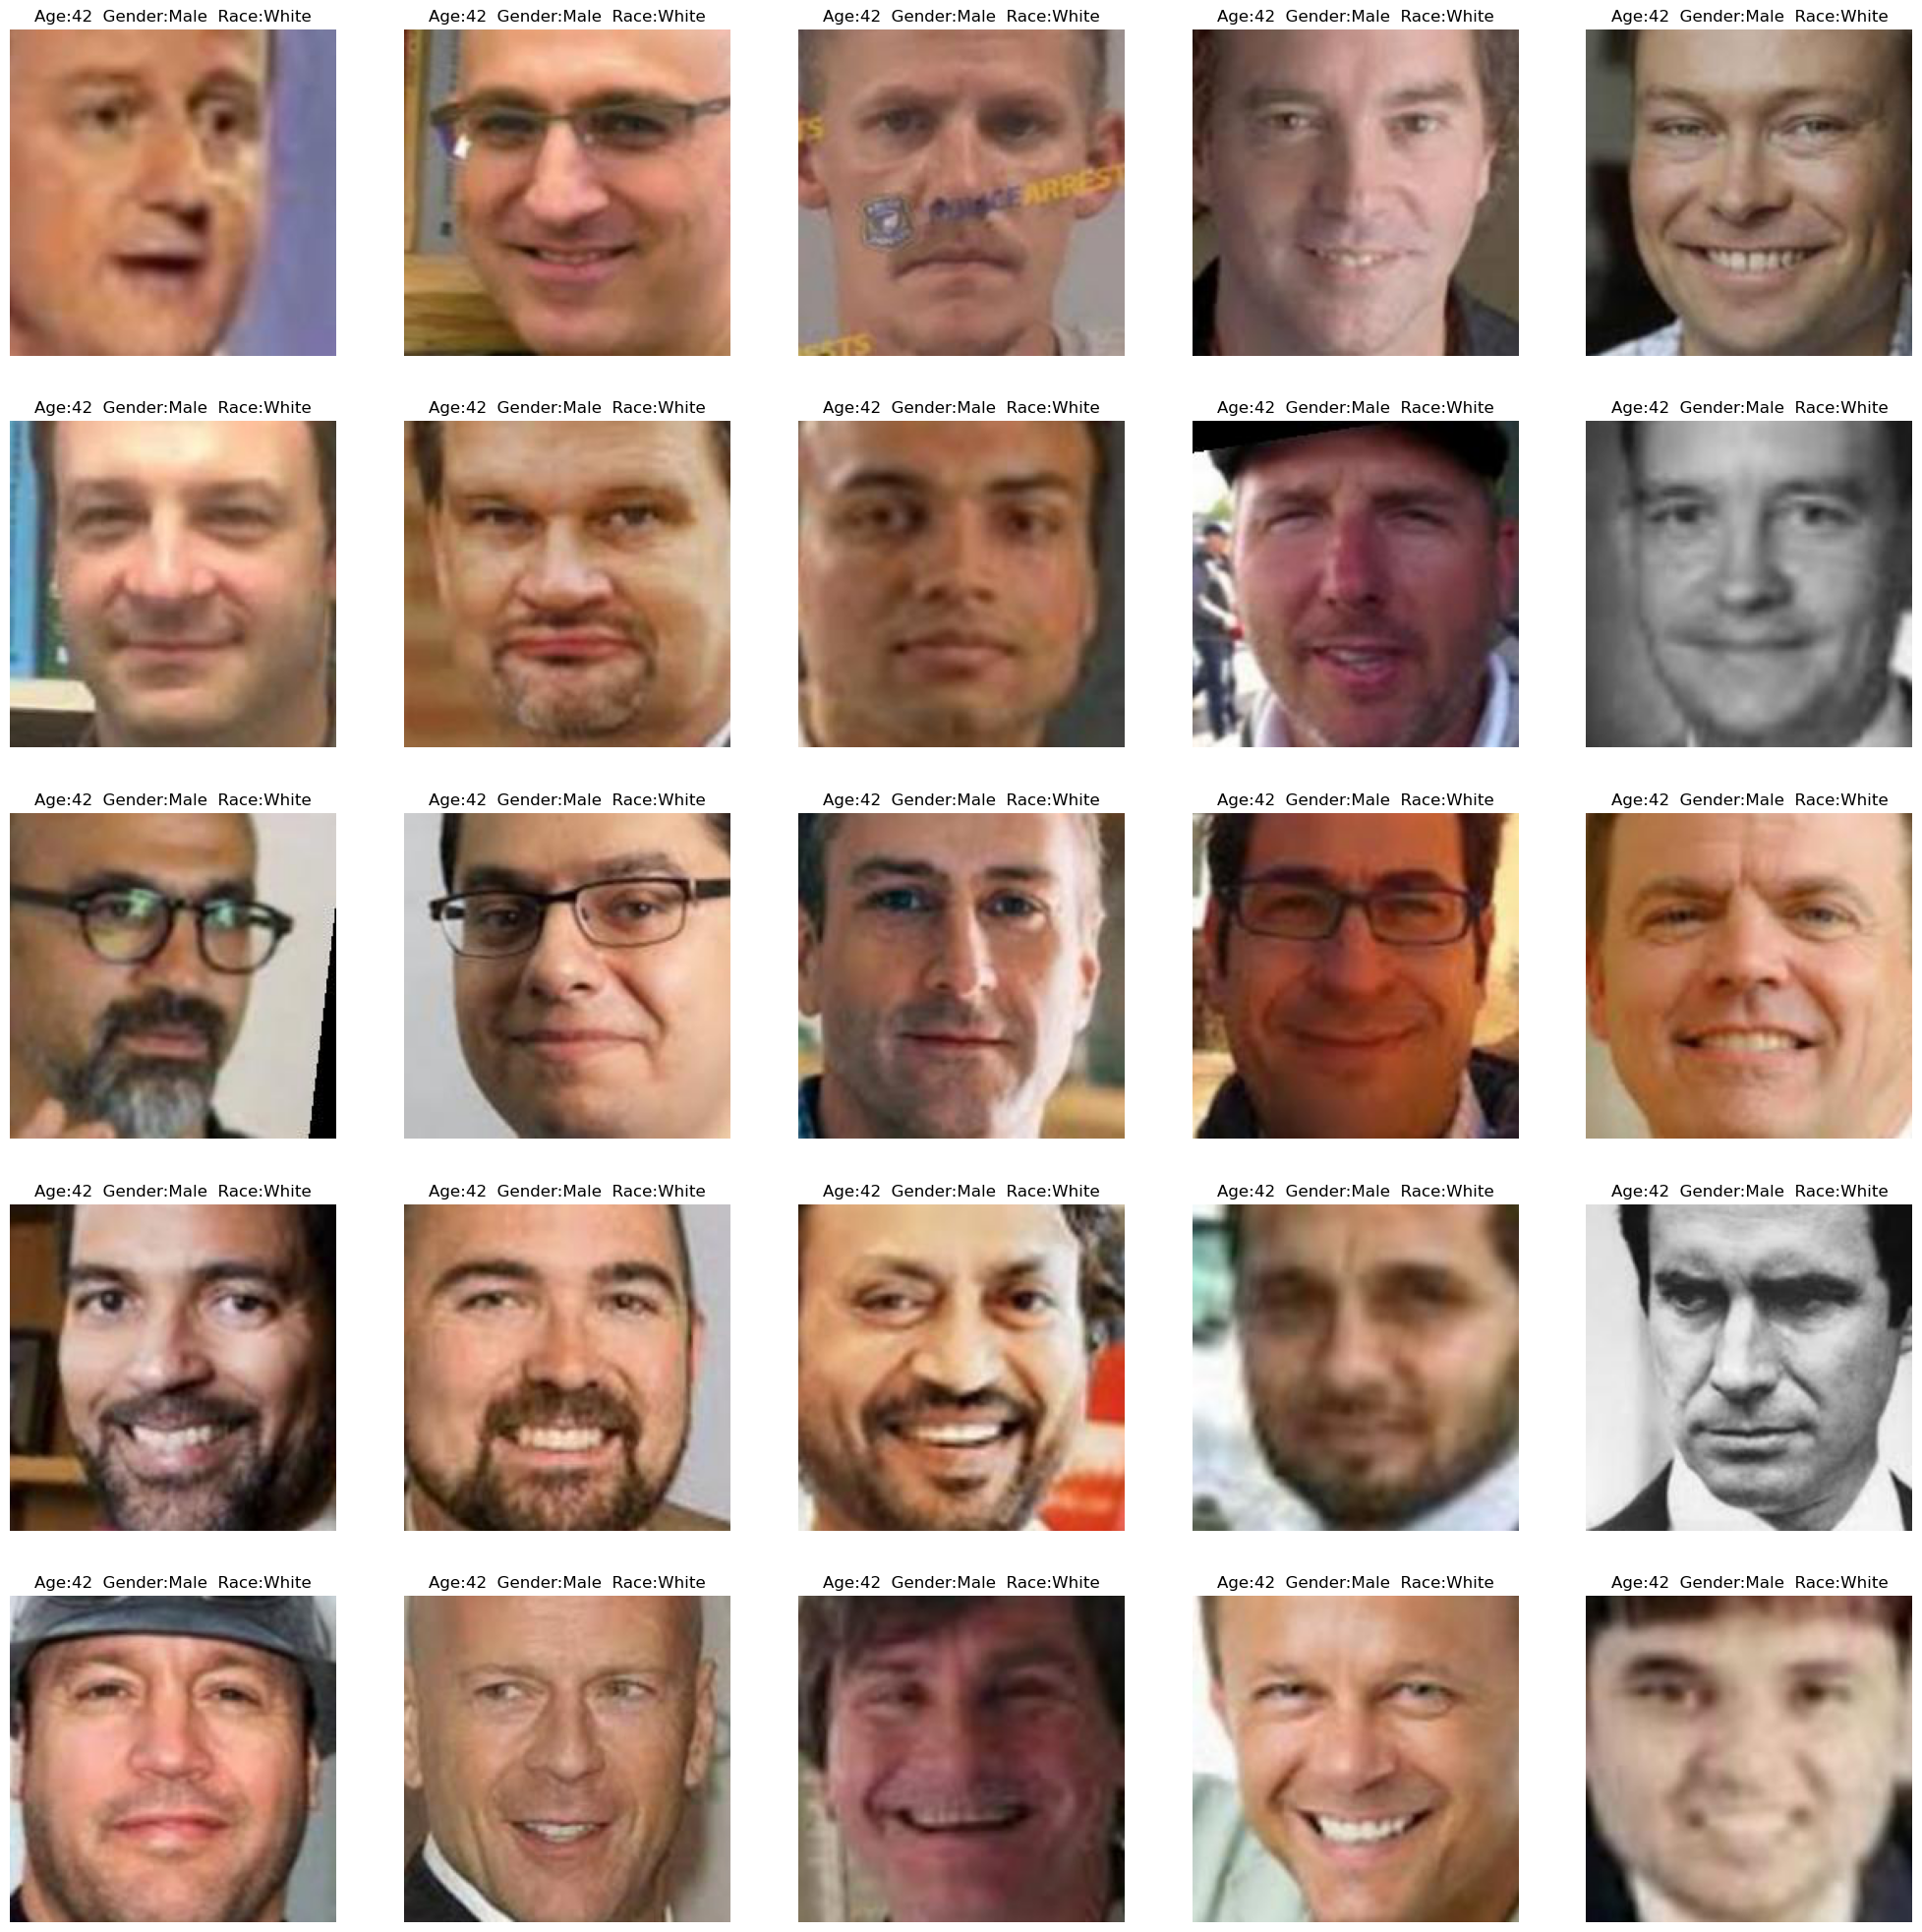

In [213]:
rand = random.randint(0,len(df.index)-25)
files = df.iloc[rand:rand+25]

plt.figure(figsize=(25,25))

i = 0
for index,file,age,gender,race in files.itertuples():
    plt.subplot(5,5,i+1)
    img = Image.open(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age:{age}  Gender:{gender_dict[gender]}  Race:{race_dict[race]}")
    plt.axis('off')
    i+=1

## Feature Extraction

In [214]:
#HOG Function

def compute_hog_features(image_paths):
    hog_features_list = []
    
    for path in image_paths:
        image = io.imread(path, as_gray=True)
        resized_image = transform.resize(image, (64, 64))
        hog_features = hog(resized_image, orientations=9, feature_vector=True)
        
        hog_features_list.append(hog_features)
    
    return hog_features_list

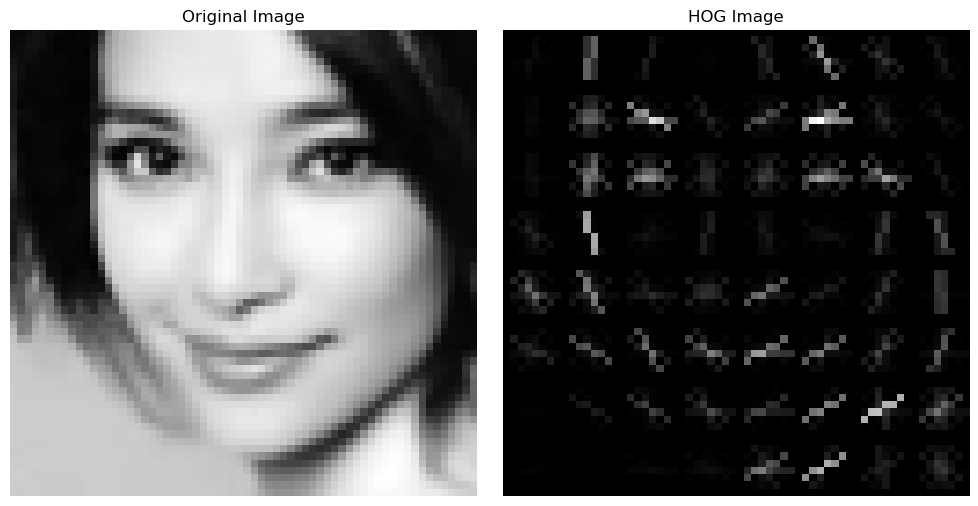

In [215]:
#Test for image

rand = random.randint(0,len(df.index))
image = io.imread(df['image'][rand], as_gray=True)

resized_image = resize(image, (64, 64))

hog_features, hog_image = hog(resized_image, orientations=9, pixels_per_cell=(8,8),
                              cells_per_block=(1, 1), visualize=True)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(resized_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(hog_image_rescaled, cmap='gray')
axes[1].set_title('HOG Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()


### Computing HOG Features

In [216]:
X = compute_hog_features(df['image'])

In [246]:
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 60, 80, float('inf')], labels=[1,2,3,4])

In [247]:
df.head()

,image,age,gender,race,age_group,cluster
0,src/utkface/100_0_0_20170112213500903.jpg.chip...,100,0,0,4,0
1,src/utkface/100_0_0_20170112215240346.jpg.chip...,100,0,0,4,1
2,src/utkface/100_1_0_20170110183726390.jpg.chip...,100,1,0,4,2
3,src/utkface/100_1_0_20170112215032192.jpg.chip...,100,1,0,4,0
4,src/utkface/100_1_0_20170119212053665.jpg.chip...,100,1,0,4,0


In [248]:
X = np.array(X)
y_age = df['age_group']
y_gender = df['gender']

nan_counts = df.isnull().sum()
print(nan_counts)

image        0
age          0
gender       0
race         0
age_group    0
cluster      0
dtype: int64


In [249]:
AgeClasses ={
    1:"Kid(0-17)",
    2:"Adult(18-59)",
    3:"Old(60-79)",
    4:"Senior(More Than 80)",   
}
# bins=[0, 18, 60, 80, float('inf')]

In [250]:
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X , y_age, test_size=0.3, stratify=y_age, random_state=42)

## Hyperparamater

c:\Users\haazm\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\haazm\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

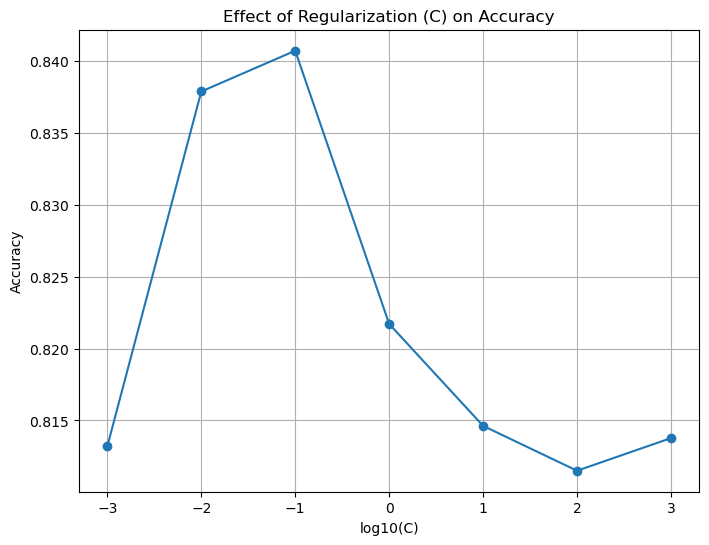

In [260]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

accuracies = []
for c in C_values:
    model = LogisticRegression(C=c)
    model.fit(X_train_age, y_train_age)
    
    predictions = model.predict(X_test_age)
    
    accuracy = accuracy_score(y_test_age, predictions)
    accuracies.append(accuracy)

plt.figure(figsize=(8, 6))
plt.plot(np.log10(C_values), accuracies, marker='o')
plt.title('Effect of Regularization (C) on Accuracy')
plt.xlabel('log10(C)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


## Logistic Regression

In [251]:
age_model = LogisticRegression(C=0.1, solver="sag") # sag
age_model.fit(X_train_age, y_train_age)

#OVR Model For real 

c:\Users\haazm\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.1, solver='sag')

In [252]:
age_predictions = age_model.predict(X_test_age)

accuracy1 = age_model.score(X_test_age,y_test_age) 
accuracy = accuracy_score(y_test_age, age_predictions)
print(f"Accuracy for Age Prediction: {accuracy:.2f}")


Accuracy for Age Prediction: 0.84


In [253]:
train_predictions = age_model.predict(X_train_age)
train_accuracy = accuracy_score(y_train_age, train_predictions)

# Predictions on test set
test_predictions = age_model.predict(X_test_age)
test_accuracy = accuracy_score(y_test_age, test_predictions)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.8892
Test Accuracy: 0.8396


2


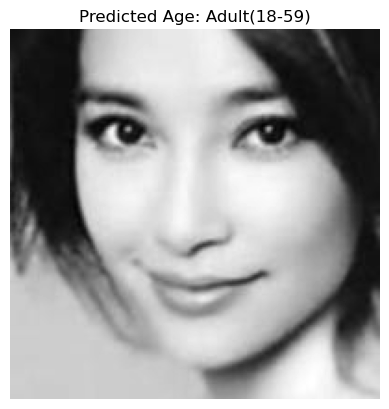

In [225]:
random_prediction = age_model.predict(X_test_age)
print(random_prediction[0])

plt.imshow(image, cmap='gray')
plt.title(f"Predicted Age: {AgeClasses[random_prediction[0]]}")
plt.axis('off')
plt.show()


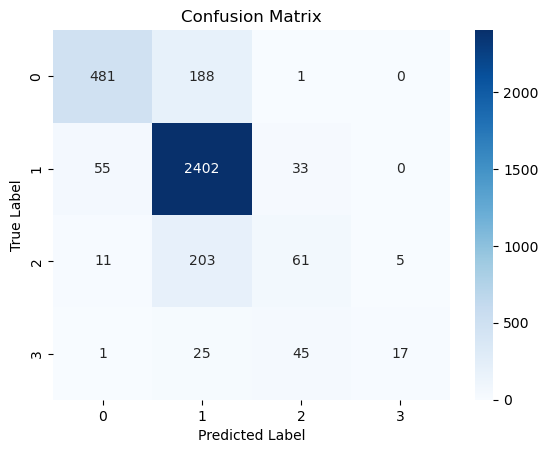

In [226]:

y_pred = age_model.predict(X_test_age)
cm = confusion_matrix(y_test_age, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

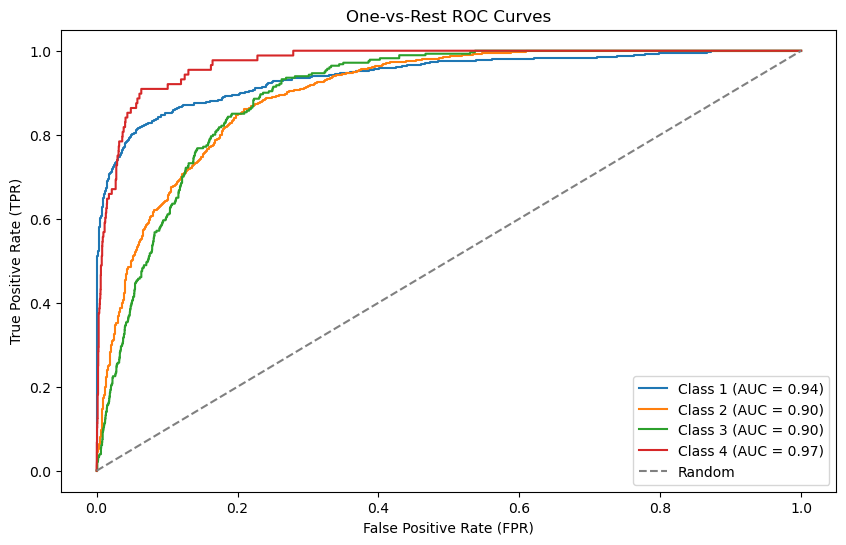

In [227]:
y_prob = age_model.predict_proba(X_test_age)

y_test_bin = label_binarize(y_test_age, classes=age_model.classes_)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(age_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i in range(len(age_model.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('One-vs-Rest ROC Curves')
plt.legend()
plt.show()

From the roc_curve we can conclude that the model excels in categorizing the classes in this order:\
Senior 0.96\
Kid    0.94\
Old    0.90\
Adult  0.88

Senior(80+) is the easiest, Adult(18-49) is the hardest

## KMeans Clustering

In [228]:
# Scale data by minmax 
Scaler = MinMaxScaler()
X = Scaler.fit_transform(X)
X


array([[4.80960686e-01, 1.59902416e-01, 1.69191609e-02, ...,
        1.59851242e-03, 0.00000000e+00, 5.18138978e-04],
       [5.56149361e-01, 5.03608175e-01, 2.29380659e-02, ...,
        8.18380352e-02, 2.18009908e-03, 0.00000000e+00],
       [5.94044732e-01, 6.80382685e-01, 2.30612581e-01, ...,
        7.31046645e-02, 1.01934227e-02, 1.84335136e-02],
       ...,
       [6.46225184e-02, 2.88836954e-02, 3.59889955e-02, ...,
        2.93857948e-02, 2.04855469e-02, 4.68096107e-02],
       [5.11245491e-01, 3.20608419e-03, 2.08527141e-04, ...,
        8.39654853e-03, 3.95261703e-02, 2.05677303e-01],
       [2.96122997e-01, 4.42385168e-01, 2.09716040e-01, ...,
        1.04167762e-01, 1.87936430e-01, 2.85717512e-01]])

In [229]:
max_clusters = 5 # as required in project docs

inertia = []
silhouette = []
for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=400, init='k-means++', random_state=42)
    kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, kmeans.labels_))


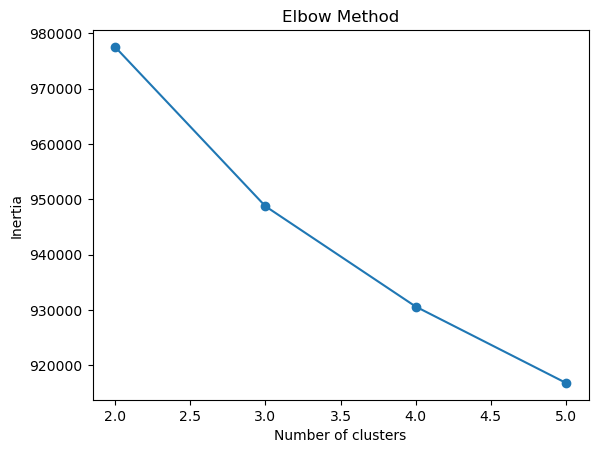

In [230]:
# plot the elbow graph with a maximum of 5 clusters
plt.plot(range(2, max_clusters + 1), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [231]:
print(inertia)

[977567.8222537041, 948773.8013004618, 930628.2383681934, 916825.433784294]


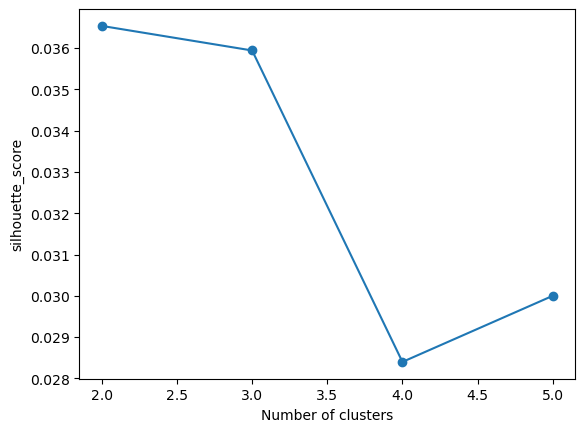

In [232]:
# plot the silhouette_score graph with a maximum of 5 clusters
plt.plot(range(2, max_clusters + 1), silhouette, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette_score')
plt.show()

In [233]:
print(silhouette)

[0.03653729086879655, 0.03594236437453632, 0.028399259519160516, 0.030000564811841584]


In [234]:
# best n cluster is 4 from the graph
kmean = KMeans(n_clusters=3, n_init=10, max_iter=400, init='k-means++', random_state=42)

clusters = kmean.fit_predict(X)
df['cluster'] = kmean.labels_

In [235]:
print(kmean.inertia_)
print(silhouette_score(X, df['cluster']))

948773.8013004618
0.03594236437453632


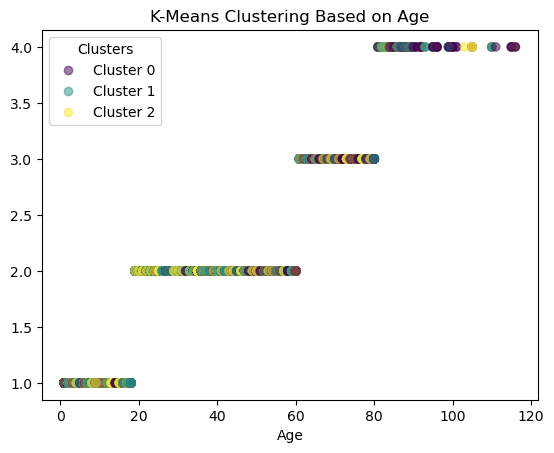

In [236]:
scatter = plt.scatter(df['age'], df['age_group'], c=clusters, cmap='viridis', alpha=0.5)

legend_labels = [f'Cluster {i}' for i in range(clusters.size)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters')

plt.xlabel('Age')
plt.title('K-Means Clustering Based on Age')
plt.show()

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

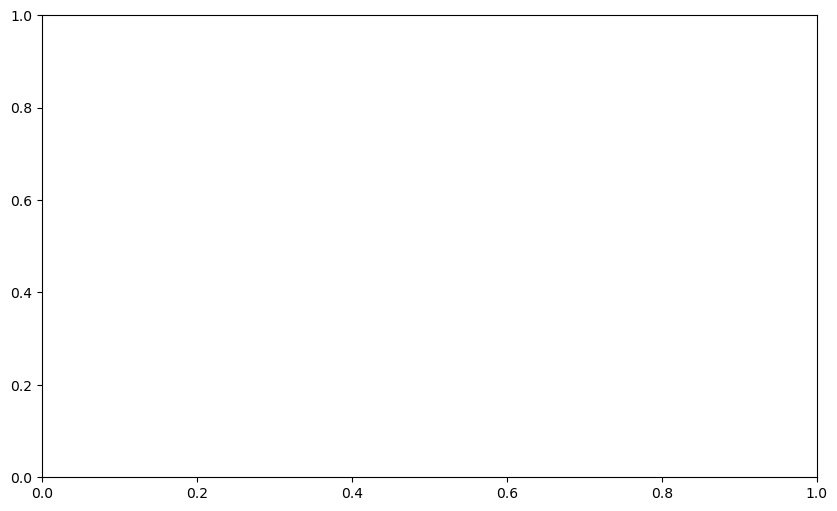

In [254]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=clusters, y='age', data=df, hue=clusters)
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.title('Distribution of Ages within Clusters')
plt.show()

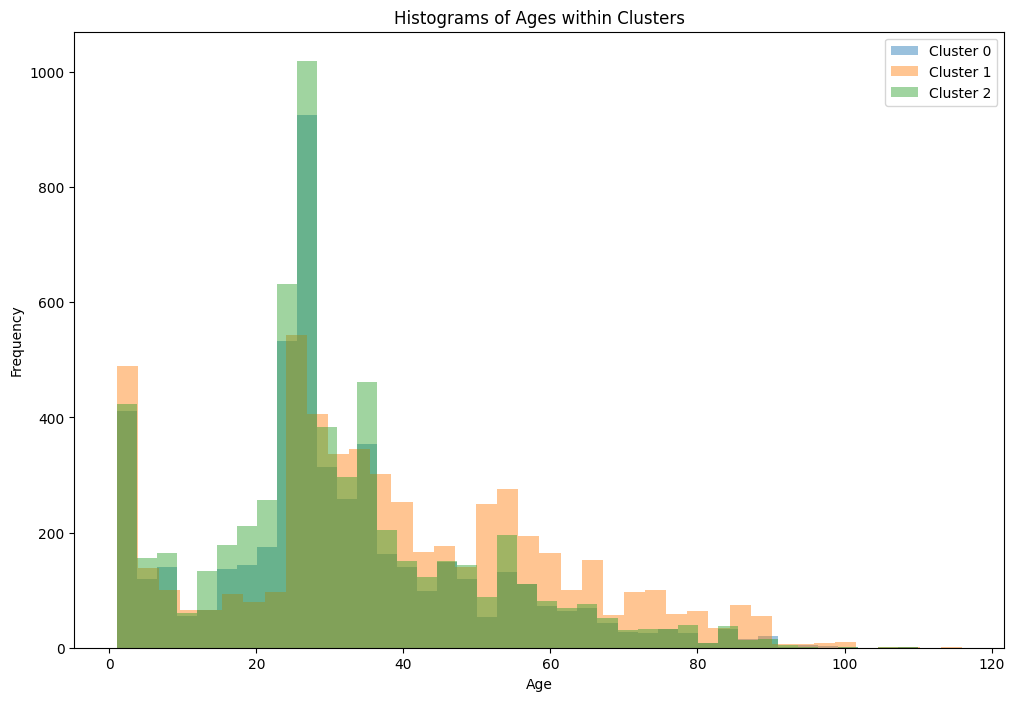

In [ ]:
plt.figure(figsize=(12, 8))
for cluster_label, cluster_data in df.groupby(clusters):
    plt.hist(cluster_data['age'], bins=40, alpha=0.45, label=f'Cluster {cluster_label}')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histograms of Ages within Clusters')
plt.legend()
plt.show()